# 动手学随机模拟（基于python）

各位同学，大家好！在前面一个任务中，我们主要学习了随机过程及其在生活中的仿真，主要的应用场景是：交通与金融。本次任务，我们将深入学习如何使用概率统计工具帮助我们对现实生活中的随机现象进行模拟。上一个任务，我们学习的方法主要是通过知识点推动案例的形式，如：先学习什么是泊松过程、泊松过程有什么性质，再来学习如何使用泊松过程对交通流进行仿真。这种学习的方法的好处在于能通过案例的形式加深知识点的掌握，帮助我们了解知识点能应用在什么场景，怎么用等等。本章节，我们主要使用案例推动的形式，从案例总结出需要的知识点，我们将会完整地经历一个建模的全过程，这个过程将十分有趣！

本任务的大纲：
- 1. 如何通过随机模拟估计看涨期权的报酬分布
     - 1.1 金融知识：股票与看涨期权
     - 1.2 问题分析与确定建模思路
     - 1.3 如何模拟股票价格：布朗运动
     - 1.4 如何更真实地模拟股票价格：几何布朗运动
     - 1.5 估计看涨期权的报酬分布
     - 1.6 随机模拟的几个关键点
- 2. 随机模拟的关键：随机数生成
     - 2.1 随机数生成的基础：均匀分布的随机数
     - 2.2 分布函数生成随机数
     - 2.3 拒绝采样生成随机数
     - 2.4 MCMC（蒙特卡洛马尔可夫）生成随机数

## 1. 如何通过随机模拟估计看涨期权的报酬分布

通过对问题“如何通过随机模拟估计看涨期权的报酬分布”的关键字拆解，我们对这个问题分解了三个关键词：随机模拟、看涨期权、报酬分布。从这个问题本身出发，可以发现该问题是一个研究随机现象的问题，因为它想要我们研究“报酬分布”。要搞清楚这个问题的关键，需要弄清什么是看涨期权，如何去定义看涨期权的报酬？

### 1.1 金融知识：股票与看涨期权

在介绍什么是看涨期权之前，我们先来看看一个例子：

假如你是一位榴莲爱好者，众所周知，榴莲的价格波动是十分明显的。现在榴莲的价格是30元一块，为了能在8月吃到美味的榴莲，你跟GitModel超市签订了协议，协议规定：现在你必须给GitModel超市2元，那么在8月的任何一天，你都能用20元买到一块榴莲。你认为，未来的榴莲价格肯定会高于$20+2=22$元，因此，你高高兴兴地签了协议。因此，在8月份会出现一下几种情况：
- 榴莲价格$Price$在22元以上，你将以$20+2 = 22$元的价格买到高于22元价值的榴莲，你将会赚$Price - 20 -2$元。
- 榴莲价格$Price$在20元以下，你可以选择不行使购买的权利，你会从别的超市以$Price$的价格买来榴莲，您将亏损2元。
- 榴莲价格$Price$在20元至22元之间，你为了能吃到榴莲，你也可以行权以20元的价格买到榴莲。

从专业术语来说，在这个例子中，你签了合约相当于买进看涨期权，榴莲就是期权的标的资产，2元的合约费相当于权利金，20元就是行权价格，到期行使合约权利叫做行权。只要榴莲的市价比总花费$22$元高，那你就赚到了。而如果榴莲的市价比总花费$22$元低，或者等于总的花费$22$元，那你可以选择不行权，最多就亏损2元的合约费。

那么，问题来了，为什么要使用看涨期权呢？对于你自身来说，由于现在无法判断榴莲未来价格的涨跌，而期权的出现就可以帮你锁定价格波动风险，如果榴莲的价格一直上涨，你获利的空间就会越来越大；但是如果榴莲的价格一直下跌，因为期权买方（购买看涨期权的人）享有权利而不用承担义务（相反，期权卖方（跟你签订看涨期权的人）承担义务但不享有权利），所以你最大的损失就是2元的合约费。

我们可以来对上面的看涨期权的例子的收益曲线进行绘制：

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei','Songti SC','STFangsong']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

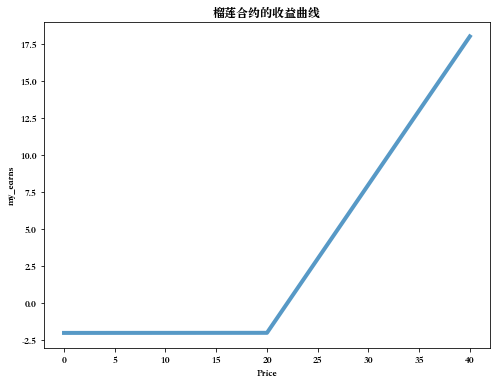

In [121]:
price_arr = np.linspace(0, 40, 10000)   # 定义价格波动，从0～100波动
def get_earnings(price: float, contract_sum: float, contract_cost: float) -> float:
    return price - (contract_sum + contract_cost) if price > contract_sum else -contract_cost

my_earn = [get_earnings(price=price, contract_sum=20, contract_cost = 2) for price in price_arr]
plt.figure(figsize=(8,6))
plt.plot(price_arr, my_earn, lw=4, alpha=0.75)
plt.xlabel("Price")
plt.ylabel("my_earns")
plt.title("榴莲合约的收益曲线")
plt.show()

现在，我们把榴莲看作一个股票，对于股票价格上涨的大涨行情来说，如果你购买了看涨期权，收益上不封顶，亏损最多就是合约金（权利金）。一般来说，权利金的数额是远远低于标的资产（股票）本身的资产价格。换句话来说，期权是有**杠杆**的，现在你用2元的本金撬动了几十元的收益，这是个十分关键的地方：
- 假如现在房子是100万，你用100万买下房子，一段时间过后房子涨到了150万，你赚了$150-100=50$万，收益率为：$\frac{150-100}{100} \times 100\% = 50\%$
- 假如你购买了一张看涨期权，价值为2万，规定未来无论该房子价格如何，都可以使用100万购买该房子。一段时间后，房子涨到了150万，你想行使权利，但是你没有100万的交易费用怎么办？这时候你可以问银行借100万（假如不算利息），用100万买了150万的房子，再把房子以150万价格卖出去，这时候你把得来的150万中的100万还给银行，剩下50万的盈利。这时候，我们计算下收益率：$\frac{50-2}{2} \times 100\% = 2400%$，也就是24倍，不是24%。因此，你是用2万的本金撬动了48万的盈利，但是你就算怎么亏损，最多也就是亏掉2万的权利金，但是亏损率是100%，这就是加了杠杆。

### 1.2 问题分析与确定建模思路

回到问题"如何通过随机模拟估计看涨期权的报酬分布"本身，我们已经知道了看涨期权以及如何计算看涨期权的报酬。看涨期权能得到报酬的关键点就是标的资产的价格，对于看涨期权来说，标的资产的价格越高，我们获得报酬相应的也会越高。因此，由于标的资产的价格如：股价在每个时刻是一个随机变量，因此我们的报酬在某个时刻是标的资产价格的函数，也是一个随机变量，这个随机变量可以用分布来表示。现在，问题的关键就是：
- （1）在某个时刻如何估计股票的价格分布
- （2）在某个时刻结合行权价格与股票的价格分布，模拟看涨期权的报酬分布

在一段时间，股票价格是一个随机过程，而看涨期权的价格（也是衍生品的价格）是随机过程的函数。那么，如何估计股票价格这个问题就衍化为使用哪个随机过程去近似股票价格这个随机过程，这个随机过程应该具备什么特点呢？我们观察一个股票的走势图：

In [122]:
# 获取工商银行股票价格数据
import baostock as bs
# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)
stock_code = 'sh.601398'
rs = bs.query_history_k_data_plus(stock_code,
                                  "date,close",
                                  start_date='2016-01-04', end_date='2021-12-31',
                                  frequency="d", adjustflag="3")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)
#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
gsyh = pd.DataFrame(data_list, columns=rs.fields)
gsyh['close'] = gsyh['close'].astype('float')
gsyh['date'] = pd.to_datetime(gsyh['date'], format='%Y-%m-%d')
gsyh

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success


,date,close
0,2016-01-04,4.45
1,2016-01-05,4.47
2,2016-01-06,4.51
3,2016-01-07,4.43
4,2016-01-08,4.46
...,...,...
1456,2021-12-27,4.66
1457,2021-12-28,4.68
1458,2021-12-29,4.66
1459,2021-12-30,4.64


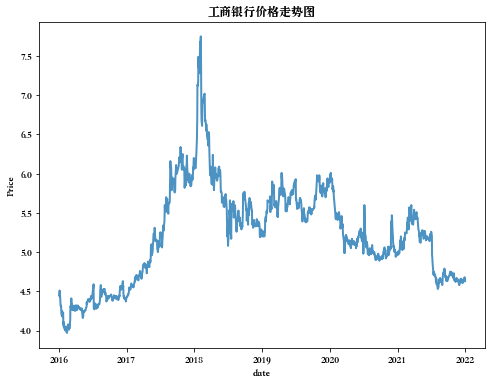

In [123]:
# 查看工商银行的价格走势图
plt.figure(figsize=(8,6))
plt.plot(gsyh['date'], gsyh['close'], lw=2, alpha=0.8)
plt.xlabel("date")
plt.ylabel("Price")
plt.title("工商银行价格走势图")
plt.show()

通过观察以上价格走势图，我们发现曲线有如下特点：
- （1）股票价格走势具有强烈的随机性；
- （2）股票价格的曲线是一条"不平滑"的曲线，与我们前面学习的可微分的曲线不太一样。

为了近似股票价格的性质，我们想到了物理世界中的布朗运动，什么是物理中的布朗运动呢？1827年英国植物学家罗伯特 • 布朗（Robert Brown）在使用显微镜观察水中花粉微粒运动时发现了微粒的无规则运动，这种无规则运动称为：布朗运动。布朗运动的无规律运动的性质很类似股票价格的无规则波动，因此可以尝试使用物理中的布朗运动去近似股票价格的无规律波动。而数学上对布朗运动的描述发展相比于物理上的布朗运动要慢一些。布朗运动的定义和描述是由诺伯特 • 维纳（Norbert Wiener）在 1918 年提出，因此布朗运动（随机过程）（Brownian motion）又称为维纳过程（Wiener process）。

### 1.3 如何模拟股票价格：布朗运动

什么是布朗运动呢？我们还是用一个简单的例子来说明：设有一个粒子在直线上随机游动, 该粒子在每个单位时间内等可能地向左或向右移动一个单位长度，观察这个例子的轨迹图：

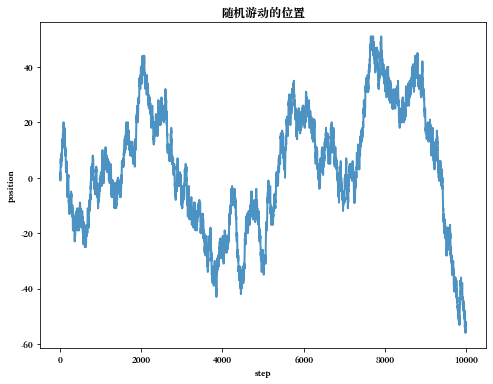

In [124]:
# 获取随机游动的位置
def get_particle_pos(n_times):
    position_ls = [0]
    for i in range(n_times-1):
        left_or_right = np.random.rand()
        if left_or_right >= 0.5:
            position_ls.append(1.0)
        else:
            position_ls.append(-1.0)
    position_ls = np.cumsum(position_ls)
    return position_ls

n_times = 10000
position_arr = get_particle_pos(n_times = n_times)
plt.figure(figsize=(8, 6))
plt.plot(np.arange(n_times), position_arr, lw=2, alpha=0.8)
plt.xlabel("step")
plt.ylabel("position")
plt.title("随机游动的位置")
plt.show()


现在，我们将粒子的随机游动与股价走势放在一起对比一下：

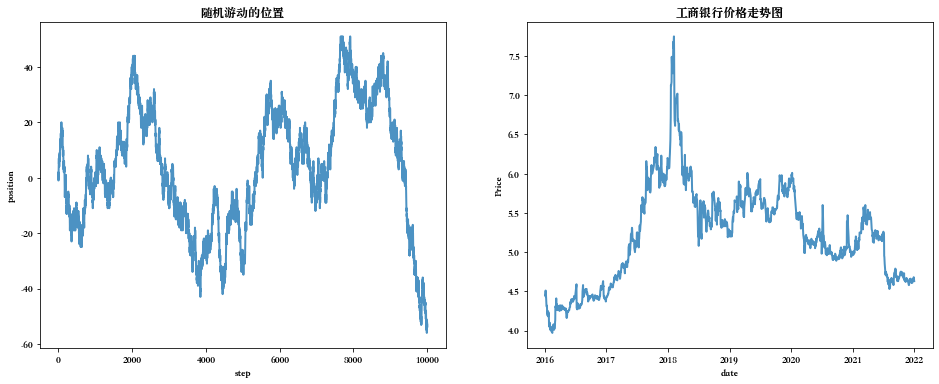

In [125]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(np.arange(n_times), position_arr, lw=2, alpha=0.8)
plt.xlabel("step")
plt.ylabel("position")
plt.title("随机游动的位置")
plt.subplot(1,2,2)
plt.plot(gsyh['date'], gsyh['close'], lw=2, alpha=0.8)
plt.xlabel("date")
plt.ylabel("Price")
plt.title("工商银行价格走势图")
plt.show()

通过对比一维布朗运动（随机游动）走势和股票价格的走势可以发现，这两者在形状上非常相似，或许我们可以将股票价格走势与一维布朗运动走势联系起来。在历史的长河中，最早使用布朗运动分析股票价格走势的人是路易斯 • 巴舍利耶，他在1900年就在博士论文中写到如何使用布朗运动描述股票价格走势和期权的价格。

那么，介绍了这么久的布朗运动，布朗运动的详细定义是什么呢？

随机过程 $\{X(t), t \geqslant 0\}$ 如果满足:
(1) $X(0)=0$;
(2) $\{X(t), t \geqslant 0\}$ 有平稳独立增量;
(3) 对每个 $t>0, X(t)$ 服从正态分布 $N\left(0, \sigma^{2} t\right)$,
则称 $\{X(t), t \geqslant 0\}$ 为 Brown 运动, 也称为 Wiener 过程, 常记为 $\{B(t), t \geqslant 0\}$ 或 $\{W(t), t \geqslant 0\}$ 。
如果 $\sigma=1$, 我们称为标准 Brown 运动; 如果 $\sigma \neq 1$, 则可考虑 $\{X(t) / \sigma, t \geqslant 0\}$, 它是标准 Brown 运动。


我们可以验证一维布朗运动（随机游走）的定义（3），即：均值函数和方差函数分别为：0与$\sigma^2 t$以及每个时刻的位置分布为正态分布。

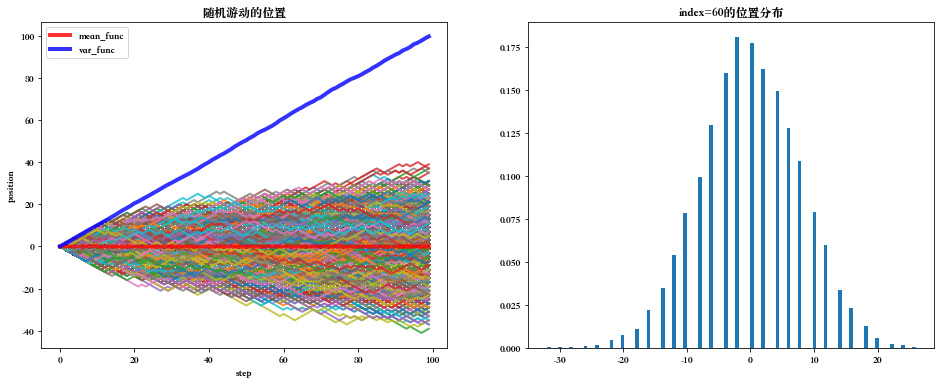

In [126]:
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
## 模拟10000次随机漫步
simulate_time = 10000
n_times = 100
result_ls = []
for i in range(simulate_time):
    position_arr = get_particle_pos(n_times=n_times)
    plt.plot(np.arange(n_times), position_arr, lw=2, alpha=0.8)
    result_ls.append(position_arr.tolist())
pos_mean = np.mean(result_ls, axis=0)
pos_var = np.var(result_ls, axis=0)
plt.plot(np.arange(n_times), pos_mean, lw=4, alpha=0.8, c='red', label='mean_func')
plt.plot(np.arange(n_times), pos_var, lw=4, alpha=0.8, c='blue', label='var_func')
plt.xlabel("step")
plt.ylabel("position")
plt.title("随机游动的位置")
plt.legend()
plt.subplot(1,2,2)
## 选取index=60的位置分布
pos_60 = np.array(result_ls)[:, 60]
plt.hist(pos_60, bins=100, density=1)
plt.title("index=60的位置分布")
plt.show()

从图中可以看到：随机游动的均值函数为0， 方差函数是一个关于时间$t$的直线函数，index为60的位置分布也符合正态分布，以上都是布朗运动的表现。

接下来，我们通过实验（非数学推导）的形式更加直观地来说明为什么使用布朗运动描述股票价格的走势是合理的。首先，我们先来绘制20条随机游动的样本轨迹：

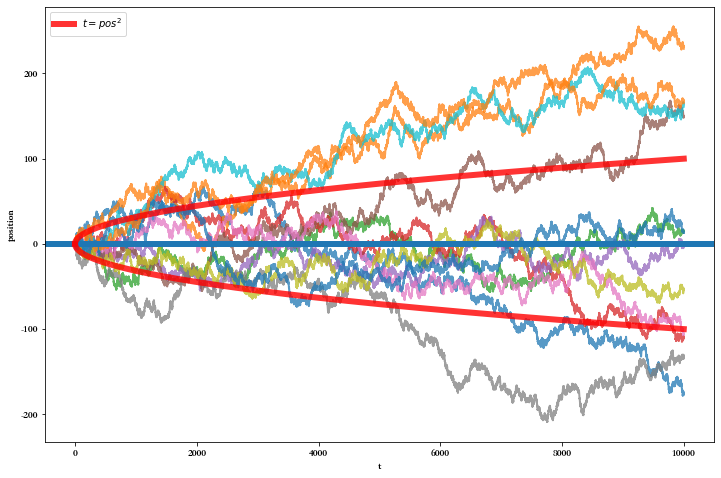

In [127]:
plt.figure(figsize=(12, 8))
simulate_times = 12
n_times = 10000
for i in range(simulate_times):
    position_arr = get_particle_pos(n_times=n_times)
    plt.plot(np.arange(n_times), position_arr, lw=2, alpha=0.75)
plt.axhline(y=0, lw=6)
plt.plot(np.arange(n_times), np.sqrt(np.arange(n_times)), lw=6, c='red', alpha=0.8, label=r'$t=pos^2$')
plt.plot(np.arange(n_times), -np.sqrt(np.arange(n_times)), lw=6, c='red', alpha=0.8)
plt.legend()
plt.xlabel("t")
plt.ylabel("position")
plt.show()

从上图可以看到：
- （1）布朗运动的轨迹线会频繁穿越$pos = 0$的水平线：图中的12条样本轨迹线大多数会频繁穿越0基准线，只有少部分曲线会不穿越0基准线（如：亮蓝色的轨迹线），但是随着时间的推移，这条亮蓝色的轨迹线也会穿越0基准线。我们把0基准线看成是股票的开盘价，频繁穿越0基准线意味着股价很大概率会在开盘价上下波动，而不是始终维持在开盘价的上方或者下方。这一点的性质在很多股票投资的实践经验都有印证，例如：现在有一种引诱投资者投资的套路：诱多，即：如果大盘平稳的话，股价从开盘价一路飙升而收盘价又回到开盘价的套路，这种套路可以很轻易地把当日追涨者的资金套住。
- （2）在任意时刻 $t$, 样本轨迹的位置 $B(t)$ 不会偏离正负一个标准差太远：我们在布朗运动的定义中的（3）可以知道，对每个 $t>0, X(t)$ 服从正态分布 $N\left(0, \sigma^{2} t\right)$，一个标准差即$\sigma \sqrt{t}$，上图中的红色曲线可以包含绝大多数的样本轨迹。这点可以说明，随着交易时间$t$的推移，$t$时刻的股票价格始终不会偏离开盘价（0基准线）$\pm \sqrt{t} \times$ 价格波动的标准差，就算偏离也不会太远（除了小概率事件）。

上面的内容，我们主要阐述了布朗运动描述股价走势的合理性，但是其不合理性也很明显。其中，最大的一个缺点就是布朗运动可以是负数，因为布朗运动的样本轨迹会频繁穿越0基准线。然而，股票价格却肯定不会是负数，这是布朗运动的理论与现实的矛盾。为了解决这个问题，我们可以改进布朗运动描述股票价格走势，使用几何布朗运动描述股票价格。

### 1.4 如何更真实地模拟股票价格：几何布朗运动

为了解决使用布朗运动描述股票价格走势会出现负数的问题，我们尝试给布朗运动加上一个仅和时间 $t$ 有关的漂移项 $\mu t$, 以及一个尺度参数 $\sigma$，这样就可以得到带漂移项的布朗运动：$X(t)=\mu t+\sigma B(t)$。即使是带漂移项和尺度参数的布朗运动 $X(t)$, 它也不是描述股票价格走势的最优选择，因为 $X(t)$ 与 $B(t)$ 的取值随着时间 $t$ 的变化也可以是负数, 但是股票的价格显然不能是负数，这种办法并没有解决实际问题。然而，我们灵机一动，虽然股票价格不能是负数，但是股票价格的自然对数可以是负数。因此，我们假设使用$S(t)$表示股票价格（注意现在不是$X(t)$了），而$X(t)$是股票价格的自然对数，即：$X(t) = ln(S(t))$。因此，带漂移项的布朗运动就变成了：
$$
X(t) = ln(S(t)) = \mu t+\sigma B(t)
$$

我们对$X(t) = ln(S(t)) = \mu t+\sigma B(t)$进行微分(简单的对数函数求导)，即：
$$
\frac{d S(t)}{S(t)}=\mu d t+\sigma d B(t)
$$

为什么要对$X(t) = ln(S(t)) = \mu t+\sigma B(t)$进行微分呢？观察上面的微分式子，可以得到一个重大发现：假设 $S(t)$ 为股票的价格, 则 $d S(t)$ 为股价在无穷小的时间间隔内的变化量, 而 $d S(t) / S(t)$ 就 是这段间隔内的收益率,我们使用对数价格的微分建模竟然是收益率的建模！化简上述的式子$\frac{d S(t)}{S(t)}=\mu d t+\sigma d B(t)$得到：
$$
d S(t)=\mu S(t) d t+\sigma S(t) d B(t)
$$

式子：$d S(t)=\mu S(t) d t+\sigma S(t) d B(t)$是一个微分方程，这个微分方程是带有随机性的微分方程，简称"随机微分方程"。因此，**满足上述随机微分方程$d S(t)=\mu S(t) d t+\sigma S(t) d B(t)$的股价 $S(t)$ 是一个几何布朗运动。**

直到现在，我们终于能用几何布朗运动描述股票价格走势了，但是这个随机微分方程怎么描述股价走势呢，看着式子都很麻烦啊！别着急，既然连续的麻烦，我们可以使用欧拉离散化可以得到离散时间模型：
$$
S_{t}=S_{t-\Delta t} e^{\left(\mu-\frac{1}{2} \sigma^{2}\right) \Delta t+\sigma \varepsilon_{t} \sqrt{\Delta t}}
$$

离散时间模型的参数含义：
- $S_{t}$ : 证券在t时刻的价格;
- $\mathrm{S}_{\mathrm{t}-\Delta \mathrm{t}}$ : 证券在t $-\Delta \mathrm{t}$ 时刻的价格；
- $\mu$ ：证券收益率的期望值;
- $\sigma$ ：证券收益率的波动率;
- $\varepsilon_{t}$ : 服从正态分布（期望为 0 , 方差为 1 ）

接下来，我们模拟证券初始价格为10（日收益率均值漂移项为0.005，波动率为0.25），模拟天数为300天，次数为5000次的几何布朗运动价格。

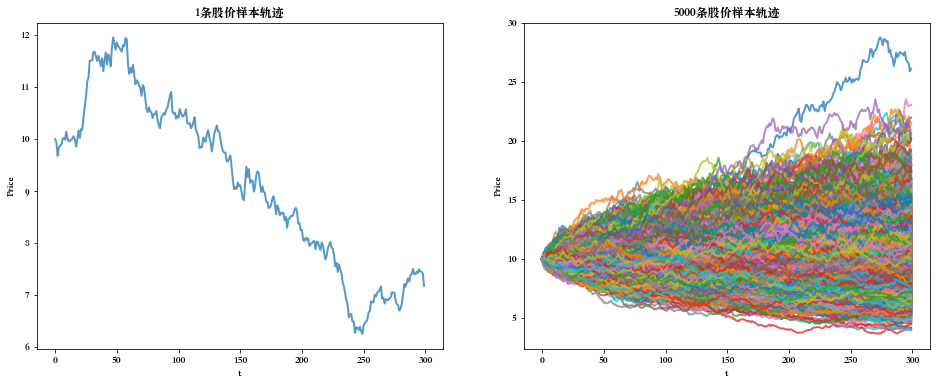

In [128]:
# 我们模拟证券初始价格为10（日收益率均值漂移项为0.005，波动率为0.25），模拟天数为300天，次数为5000次的几何布朗运动价格
S0 = 10   # 初始价格
n_days = 300   # 模拟天数
mu = 0.005
sigma = 0.25
delta_t = 1/n_days
n_times = 5000  # 模拟次数
price_arr = np.zeros((n_times, n_days))  # n_times*n_days个价格
price_arr[: , 0] = S0  # 初始价格
for t in range(1, n_days):
    price_arr[:, t] = price_arr[:, t-1]*np.exp((mu-0.5*np.square(sigma))*delta_t+sigma*np.random.standard_normal(n_times)*np.sqrt(delta_t))
# 分别绘制一条轨迹和所有轨迹
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(np.arange(n_days), price_arr[0, :], lw=2, alpha=0.75)
plt.xlabel("t")
plt.ylabel("Price")
plt.title("1条股价样本轨迹")
plt.subplot(1,2,2)
for i in range(n_times):
    plt.plot(np.arange(n_days), price_arr[i, :], lw=2, alpha=0.75)
plt.xlabel("t")
plt.ylabel("Price")
plt.title("5000条股价样本轨迹")
plt.show()

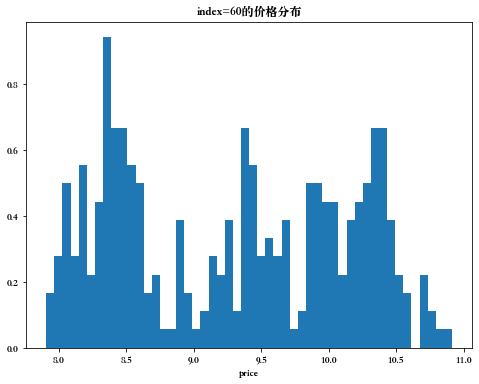

In [129]:
# 绘制某一天的价格分布
plt.figure(figsize=(8, 6))
plt.hist(price_arr[60, :], bins=50, density=True)
plt.xlabel("price")
plt.title("index=60的价格分布")
plt.show()

以上的案例给定了离散时间模型的参数值，这是一种只会存在于习题中的情况，因为当我们想模拟一只具体的股票时，这些参数信息不会一下子弹到我们脑边，我们需要根据实际数据估计其中的参数值。估计方法如下（不给证明了）：
$$
\begin{aligned}
\mu &=E\left[\ln \left(\frac{S_{t+\Delta t}}{S_{t}}\right)\right] / \Delta t \\
\sigma^{2} &=\operatorname{var}\left[\ln \left(\frac{S_{t+\Delta t}}{S_{t}}\right)\right] / \Delta t
\end{aligned}
$$

login success!
login respond error_code:0
login respond  error_msg:success
query_history_k_data_plus respond error_code:0
query_history_k_data_plus respond  error_msg:success
==============开始模拟================
初始价格： 4.63
估计的mu =  -0.07920499347383164
估计的sigma =  0.13628354313803137


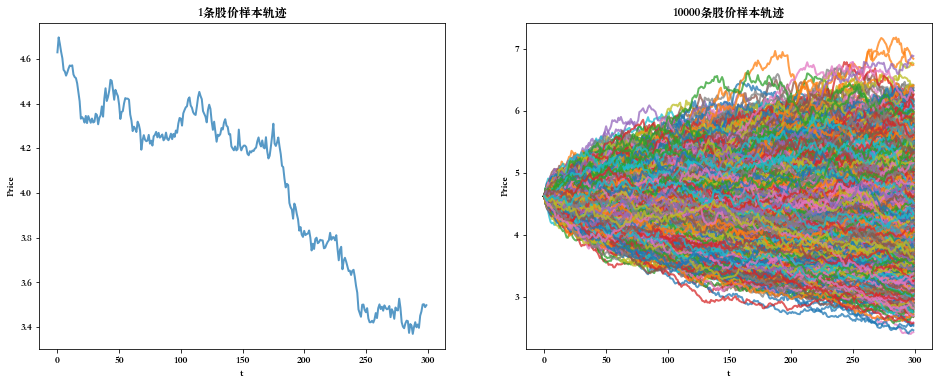

In [130]:
# 使用工商银行股票价格数据和几何布朗运动模拟股价
## 1. 获取2021年的工商银行股票价格数据
# 登陆系统
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)
stock_code = 'sh.601398'
rs = bs.query_history_k_data_plus(stock_code,
                                  "date,close",
                                  start_date='2021-01-01', end_date='2021-12-31',
                                  frequency="d", adjustflag="3")
print('query_history_k_data_plus respond error_code:'+rs.error_code)
print('query_history_k_data_plus respond  error_msg:'+rs.error_msg)
#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
gsyh_2021 = pd.DataFrame(data_list, columns=rs.fields)
gsyh_2021['close'] = gsyh_2021['close'].astype('float')
gsyh_2021['date'] = pd.to_datetime(gsyh_2021['date'], format='%Y-%m-%d')

## 2.估计几何布朗运动中的mu和sigma
price_ls = gsyh_2021['close'].tolist()
delta_t = 1/len(price_ls)
mu = np.mean(np.log(price_ls[1:]) - np.log(price_ls[:-1]))  / delta_t
sigma2 = np.var(np.log(price_ls[1:]) - np.log(price_ls[:-1]))  / delta_t
## 3.使用几何布朗运动模拟股价走势
print("==============开始模拟================")
S0 = price_ls[-1]   # 初始价格
print("初始价格：", S0)
n_days = 300   # 模拟天数
sigma = np.sqrt(sigma2)
print("估计的mu = ", mu)
print("估计的sigma = ", sigma)
delta_t = 1/n_days
n_times = 10000  # 模拟次数
price_arr = np.zeros((n_times, n_days))  # n_times*n_days个价格
price_arr[: , 0] = S0  # 初始价格
for t in range(1, n_days):
    price_arr[:, t] = price_arr[:, t-1]*np.exp((mu-0.5*np.square(sigma))*delta_t+sigma*np.random.standard_normal(n_times)*np.sqrt(delta_t))
# 分别绘制一条轨迹和所有轨迹
plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(np.arange(n_days), price_arr[0, :], lw=2, alpha=0.75)
plt.xlabel("t")
plt.ylabel("Price")
plt.title("1条股价样本轨迹")
plt.subplot(1,2,2)
for i in range(n_times):
    plt.plot(np.arange(n_days), price_arr[i, :], lw=2, alpha=0.75)
plt.xlabel("t")
plt.ylabel("Price")
plt.title("10000条股价样本轨迹")
plt.show()

因此，我们可以从上述模拟中得到第300天的模拟价格分布，即：

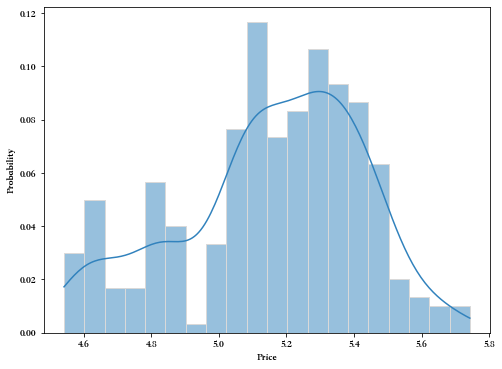

In [131]:
# 第300天的模拟价格分布
import seaborn as sns
palette = plt.get_cmap('tab20c')
price_300 = price_arr[299, :]
plt.figure(figsize=(8,6))
sns.histplot(price_300, kde = True, stat='probability', bins = 20, shrink = 1, color = palette.colors[0], edgecolor = palette.colors[-1])
plt.xlabel("Price")
plt.show()

经过一系列的努力，我们终于完成了使用几何布朗运动模拟股价走势的任务。最后，我们使用一个小案例结束本小节：我们通过带漂移项的布朗运动$X(t)=\mu t+\sigma B(t)$可以知道，$X(t)$ 的期望为 $E[X(t)]=\mu t$，即t时刻的价格期望为$\mu t$。这是个十分有趣的结论，因为假如$\mu > 0$，那么t时刻的价格期望也会大于0。因此如果我们坚信股市长期来看是一个向上的牛市（虽然很缓慢），那么我们就应该接受短期波动而坚持长期持股，就像巴菲特的价值投资一样。

### 1.5 估计看涨期权的报酬分布

现在，我们已经能够给出某天的股票价格分布，现在我们假设行权价格是4.7元，我们来分析报酬在第300天的时候的报酬分布情况（忽略权利金、远期利率和股息）：
- 当股票价格大于行权价格，那么我将获利；
- 当股票价格小于行权价格，那么我将亏损；

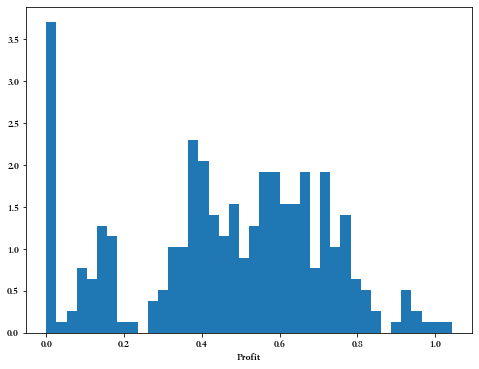

In [132]:
# 绘制报酬分布图
price_300 = price_arr[299, :].tolist()
contract_sum = 4.7
profit_sum = [price - contract_sum if price > contract_sum else 0 for price in price_300]
plt.figure(figsize=(8,6))
plt.hist(profit_sum, bins=40, density=True)
plt.xlabel("Profit")
plt.show()

### 1.6 随机模拟的几个关键点

我们回顾以下"看涨期权的报酬分布"这个案例的步骤，无论是布朗运动还是几何布朗运动，都需要大量随机数的参与，如：布朗运动中随机游动的案例的控制向左还是向右走的0-1分布的随机数、几何布朗运动中控制随机项的服从正态分布的随机数$\varepsilon_{t}$。因此，我们可以将随机模拟分解为以下步骤：
- （1）确定事件的过程（仿真）；
- （2）在事件中添加合适的分布的随机数（随机模拟）；（关键）
- （3）得到模拟的结论；

那么，在实际的编程中很多随机数都能通过python第三方包如：numpy、scipy等给出，这些第三方包给出的随机数分布往往是常用的，如：均匀分布、正态分布、指数分布等等。然而，在很多随机模拟的案例中，我们往往需要构造自己想要的分布的随机数，因此下一任务中我们主要学习几个构造随机数的方法，这类构造随机数的方法也叫采样算法（因为要从某个分布中采样，采样的样本就是所谓的随机数），如：拒绝采样、MCMC采样等等。

## 2.随机模拟的关键：随机数生成

本任务，我们来解决上个任务中总结出来的规律：随机模拟的关键点在于给出满足某个分布的随机数。构造随机数的方法非常多，这类方法也叫做采样算法，我们选其中最常用的算法给大家介绍：
- 计算机生成随机数的基础算法：均匀分布采样
- 分布函数采样
- 拒绝采样
- MCMC采样

### 2.1 随机数生成的基础：均匀分布的随机数

一般来说，均匀分布是最简单但同时是最重要的分布形式，如何对均匀分布采样直接影响着其他分布的采样。在计算机中生成[0,1]之间的伪随机数序列, 可以看做是均匀分布。伪随机数生成的方法有很多, 比较简单的一种方式比如:
$$
\mathrm{x}_{\mathrm{n}+1}=(\mathrm{ax_n} +\mathrm{c}) \bmod \mathrm{m}
$$

其中, $X$ 为伪随机序列,
- $m, m>0$, 模数, 也是生成序列的最大周期
- $a, 0<a<m$, 乘数
- $c, 0 \leq c<m$, 增量
- $X_{0}, 0 \leq X_{0}<m$, 种子点 (起始值)

$\mathrm{X}_{\mathrm{n}} / n$ 近似服从 $(0,1)$ 上的均匀分布。

这种方法叫线性同余法，使用线性同余法时需要特别小心参数设置，否则生成的随机数将会十分糟糕。下面通过一组实验看看不同的参数设置下生成的随机数序列：

In [164]:
# 线性同余法
def get_uniform_sample(a, c, m, x0, n_times):
    uniform_ls = []
    for i in range(n_times):
        uniform_sample = (a*x0+c) % m
        uniform_ls.append(uniform_sample)
        x0 = uniform_sample
    return uniform_ls

n_times = 10   # 实验次数
## 第一组实验：
a, c, m, x0 = 11, 0, 8, 1
uniform_ls = get_uniform_sample(a, c, m, x0, n_times)
print("第一次实验：")
print("a = %d, c = %d, m = %d, x0 = %d:\n" % (a, c, m, x0))
print(uniform_ls)
print("============================")
## 第二组实验：
a, c, m, x0 = 25214903917, 11, 2**48, 1  # 这也是java.util.Random中的默认参数设置
uniform_ls = get_uniform_sample(a, c, m, x0, n_times)
print("第二次实验：")
print("a = %d, c = %d, m = %d, x0 = %d:\n" % (a, c, m, x0))
print(uniform_ls)

第一次实验：
a = 11, c = 0, m = 8, x0 = 1:

[3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
第二次实验：
a = 25214903917, c = 11, m = 281474976710656, x0 = 1:

[25214903928, 206026503483683, 245470556921330, 105707381795861, 223576932655868, 102497929776471, 87262199322646, 266094224901481, 44061996164032, 147838658590923]


In [141]:
# 在numpy中，我们只需要np.random.uniform(low, high, size)就可以构造size个low～high的均匀分布的随机数
uniform_ls = np.random.uniform(0, 1, 10)
print(uniform_ls)

[0.71364912 0.59925289 0.10660613 0.38554986 0.05717685 0.48277086
 0.85735629 0.59281279 0.62027365 0.40008649]


上面的线性同余法是构造均匀分布的随机数,如果我们需要构造满足某个离散分布的随机数，如：$x = 1, 2, 3, 4$分别满足概率$[0.1, 0.3, 0.5, 0.1]$这个离散分布的随机数。其实这个问题的解决方法并不难，需要用到均匀分布的随机数：
- 生成一个$[0,1]$的均匀分布的随机数$x$；
- 如果$x$在$[0, 0.1)$，那么$x = 1$， 如果$x$在$[0.1, 0.4)$，那么$x = 2$，如果$x$在$[0.4, 0.9)$，那么$x = 3$，如果$x$在$[0.9, 1)$，那么$x = 4$。
- 重复以上步骤n_times次就能获得n_times个符合离散分布的随机数。

In [161]:
# 生成10000个离散分布的随机数
from collections import Counter
def get_discrete_sample(x_ls, p_ls, size):
    """
    :param x_ls: 类别序列
    :param p_ls: 类别的概率序列
    :param size: 生成随机数个数
    :return: 随机数序列
    """
    p_ls = np.cumsum(p_ls)  # [0.1, 0.4, 0.9, 1]
    x_sample_ls = []
    for i in range(size):
        p_uniform = np.random.uniform(0, 1)
        tmp_ls = [1 if p_uniform < p else 0 for p in p_ls]
        index = len(tmp_ls) - np.sum(tmp_ls)
        x_sample_ls.append(x_ls[index])
    return x_sample_ls

size = 10000
x_ls = [1, 2, 3, 4]
p_ls = [0.1, 0.3, 0.5, 0.1]
x_sample_ls = get_discrete_sample(x_ls, p_ls, size)
x_count = Counter(x_sample_ls)
x_count = list(x_count.items())
x_ratio = [(x[0], x[1] / len(x_sample_ls)) for x in x_count]
print(x_ratio)

[(2, 0.2982), (4, 0.1008), (3, 0.4992), (1, 0.1018)]


### 2.2 分布函数生成随机数

刚刚的线性同余法只是构造均匀分布的随机数，那能否像构造离散分布的随机数一样，通过使用均匀分布的随机数构造别的分布的随机数呢？答案是肯定的，这个方法叫逆变换法。

逆变换法的理论依据是：假设 $\mathrm{X}$ 是一个连续型随机变量，它的累积分布函数为 $F_{X}(x)$ ； 现在，定义随机变量 $Y=F_{X}(X)$ 。那么， $Y$ 服从 $(0,1)$ 上的均匀分布，即
$$
P(Y \leq y)=y, 0<y<1 \text {. }
$$

换句话说，任意分布的分布函数值服从$(0,1)$上的均匀分布，那么我们可以通过这个理论通过均匀分布构造其他分布的随机数。

接下来，我们尝试使用逆变换法通过均匀分布的随机数构造指数分布的随机数：
- 指数分布的概率密度函数为 $f_{X}(x)=$ $\lambda e^{-\lambda x}, x>0$ ，它的累积分布函数为
$$
\mathrm{F}_{X}(x)=1-e^{-\lambda x}, \quad \mathrm{x} \geq 0
$$

- 产生 $(0,1)$ 均匀分布的随机数 $V$（当作是指数分布的分布函数值）
- 令 $Y=-\frac{1}{\lambda} \log (V)$（将满足均匀分布的分布函数进行逆变换），$Y$ 即为服从指数分布的随机数

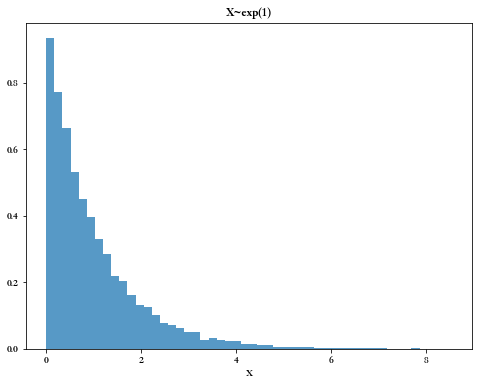

In [168]:
# 逆变换法构造指数分布的随机数
def get_exp_sample(lmd, size):
    uniform_samples = np.random.uniform(0, 1, size)
    exp_samples = []
    for uniform_sample in uniform_samples:
        exp_sample = -1.0/lmd*np.log(uniform_sample)
        exp_samples.append(exp_sample)
    return exp_samples

lmd = 1
size = 10000
exp_samples = get_exp_sample(lmd, size)
plt.figure(figsize=(8, 6))
plt.hist(exp_samples, bins=50, density=True, alpha=0.75)
plt.xlabel("X")
plt.title("X~exp(1)")
plt.show()

### 2.3 拒绝采样生成随机数

逆变换法生成均匀分布外的采样十分好用，但是这里需要知道采样分布的分布函数的形式，因为如果不知道采样分布的分布函数，那么将无法使用逆变换获得随机数。实际上，有没有分布的分布函数的表达不出来的呢？正态分布的分布函数就无法显式表达，只能用积分表达式。同时，逆变换法需要求分布函数和逆变换，方法太复杂。拒绝采样可以轻松解决这些问题，拒绝采样开始采用蒙特卡洛的思想构造随机数，我们先来看看下图：
- $p(x)$是我们需要采样的分布，有时候十分复杂，这里的$p(x) = 0.3 e^{-(x - 0.3)^2} + 0.7e^{-\frac{(x - 2.0)^2}{0.3}}$，其中$0 \le x \le 4$
- $q(x)$是我们的构造的分布，这里我们假设为[0, 4]的均匀分布

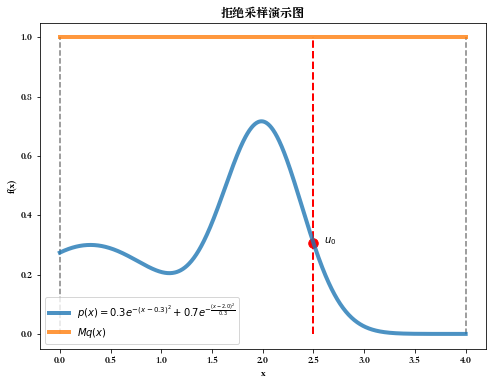

In [187]:
# 拒绝采样演示：
M = 4
z0 = 2.5
x = np.linspace(0,4,1000)
q_x = np.array([1.0/4]*1000)
p_x = 0.3*np.exp(-(x-0.3)**2)+0.7*np.exp(-(x-2.0)**2/0.3)
plt.figure(figsize=(8,6))
plt.plot(x, p_x, lw=4, alpha=0.8, label=r'$p(x) = 0.3 e^{-(x - 0.3)^2} + 0.7e^{-\frac{(x - 2.0)^2}{0.3}}$')
plt.plot(x, M*q_x, lw=4, alpha=0.8, label=r'$Mq(x)$')
plt.vlines(x=0, ymin=0, ymax=1, colors='gray',linestyles='--')
plt.vlines(x=4, ymin=0, ymax=1, colors='gray',linestyles='--')
plt.vlines(x=z0, ymin=0, ymax=1, colors='red',linestyles='--', lw=2)
plt.scatter(z0, 0.3*np.exp(-(z0-0.3)**2)+0.7*np.exp(-(z0-2.0)**2/0.3), s=90, color='red')
plt.text(z0+0.1, 0.3*np.exp(-(z0-0.3)**2)+0.7*np.exp(-(z0-2.0)**2/0.3), r'$u_0$')
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("拒绝采样演示图")
plt.show()

我们从上图可以看到，我们想要抽样的分布是蓝色的曲线$p(x)$，但是由于$p(x)$太复杂，我们无法直接采样，因此我们借助辅助的分布$q(x)$，这个辅助的分布满足一个特点：$q(x)$乘一个常数$M$后的$Mq(x)$曲线能完全包住我们想要采样的分布$p(x)$。拒绝采样的过程如下：
- 通过辅助分布$q(x)$采样$z_0$，辅助分布可以选择常见的均匀分布或者正态分布；
- 计算$u_0 = p(z_0)$（图中红色的点）；
- 在区间$(0, Mq(z_0)]$范围的均匀分布随机采样$k$，即在红色的直线范围按均匀分布采样$k$；
- 判断$k$的大小，如果$k<u_0$（即$k$位于$u_0$下方）,则接受$z_0$是来自分布$p(x)$的随机数；反之，如果如果$k \ge u_0$（即$k$位于$u_0$上方）,则拒绝$z_0$是来自分布$p(x)$的随机数。
- 重复以上过程，知道采样个数为size为止。

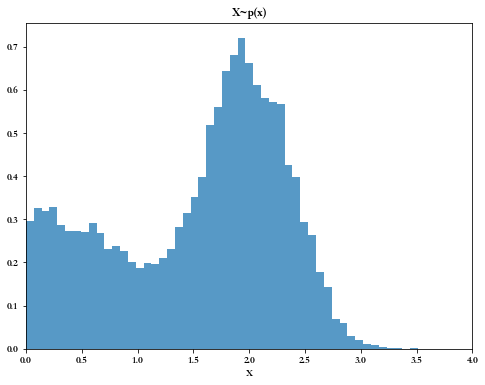

In [221]:
# 通过拒绝采样0.3*np.exp(-(x-0.3)**2)+0.7*np.exp(-(x-2.0)**2/0.3)分布的随机数
from scipy.stats import uniform
def get_px(x):
    return 0.3*np.exp(-(x-0.3)**2)+0.7*np.exp(-(x-2.0)**2/0.3)

def get_px_samples(size):
    M = 4
    px_sample_ls = []
    while len(px_sample_ls) <= size:
        z0 = np.random.uniform(0, 4)
        u0 = get_px(z0)
        k = np.random.uniform(0, M*uniform(0, 4).pdf(z0))
        if k < u0:
            px_sample_ls.append(z0)
    return px_sample_ls

size = 10000
px_samples = get_px_samples(size)
plt.figure(figsize=(8, 6))
plt.hist(px_samples, bins=50, density=True, alpha=0.75)
plt.xlim(0,4)
plt.xlabel("X")
plt.title("X~p(x)")
plt.show()

### 2.4 MCMC（蒙特卡洛马尔可夫）生成随机数

在前面随机过程的学习中，我们在马尔可夫链中又一个重要的结论：只要转移概率矩阵合适，不管初始分布如何都会收敛到同一个平稳分布。那么，我们会想到：能不能让平稳后的平稳分布刚好就是我们需要采样的分布呢？这样做有什么好处呢？事实上，如果我们能找到一个转移概率矩阵，这个矩阵得到的平稳分布刚好就是我们想要采样的分布，那么我们可以让平稳后的状态就是我们所需要的采样样本，因为这些状态都是由平稳分布得到的。总结一下，我们目前具备的已知条件是平稳分布（我们需要采样的分布），想要求一个转移概率矩阵。直接求肯定是行不通的，怎么可能由信息量少的平稳分布推出信息量多的转移概率矩阵呢？那怎么办呢？下面，我们来解决这个问题，假设平稳分布为$\pi$，转移概率矩阵为$Q$。因此，如果是随便找一个转移概率矩阵$Q$，$\pi(i) Q(i, j) \neq \pi(j) Q(j, i)$。如果想让平稳条件成立，可以引入$\alpha(i, j)$，则：
$$
\pi(i) Q(i, j) \alpha(i, j)=\pi(j) Q(j, i) \alpha(j, i)
$$
最简单的$\alpha(i, j)$与$\alpha(j, i)$是：
$$
\begin{aligned}
&\alpha(i, j)=\pi(j) Q(j, i) \\
&\alpha(j, i)=\pi(i) Q(i, j)
\end{aligned}
$$
这样, 我们就得到了我们想要采样的分布 $\pi(x)$ 对应的马尔科夫链状态转移矩阵 $P$, 满足:
$$
P(i, j)=Q(i, j) \alpha(i, j)
$$

因此，$\alpha(i, j)$ 我们有一般称之为接受率，$\alpha(i, j)$取值在 $[0,1]$ 之间, 可以理解为一个概率值（可以从均匀分布中采样）。

最后，我们总结下MCMC采样的过程：
- 输入任意的转移概率矩阵$Q(i,j)$，假设$n_1$次转移后能够到达平稳，需要采$n_2$个样本。因此采样算法从$n_1$次后才真正进行，目的是放弃平稳前的采样值，因为只有平稳后的分布才是我们的目标采样分布，如果采用了平稳前的样本，这些样本的分布将不是我们的目标分布。
- 随机产生一个初始值$x_0$
- for $t=0$ to $n_{1}+n_{2}-1$ :
       - 从条件概率分布 $Q\left(x \mid x_{t}\right)$ 中采样得到样本 $x_{*}$
       - 从均匀分布采样 $u \sim uniform[0,1]$
       - 如果 $u<\alpha\left(x_{t}, x_{*}\right)=\pi\left(x_{*}\right) Q\left(x_{*}, x_{t}\right)$ ，则接受转移 $x_{t} \rightarrow x_{*}$ ，即 $x_{t+1}=x_{*}$
       - 否则不接受转移，即 $x_{t+1}=x_{t}$
- 样本集 $\left(x_{n_{1}}, x_{n_{1}+1}, \ldots, x_{n_{1}+n_{2}-1}\right)$ （注意不能取前$n_1$个样本）即为我们需要的平稳分布对应的随机样本。

现在，我们使用MCMC采样来对$p(x) = 0.3 e^{-(x - 0.3)^2} + 0.7e^{-\frac{(x - 2.0)^2}{0.3}}$，其中$0 \le x \le 4$进行随机采样：
- 假设$Q(i,j)$为$\mu $，$\sigma$的正态分布
- 初始样本$x_0 = 0$

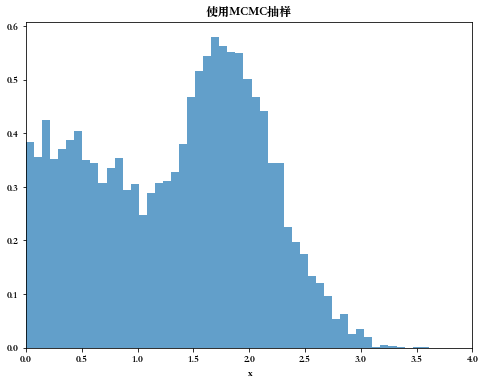

In [244]:
# 使用MCMC采样来对正态分布进行随机采样
# 定义任意分布Q的密度函数
def Gussian_q(x,mu,sigma):
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-np.square((x-mu))/(2*np.square(sigma)))

# 从任意分布Q中获取一个样本
def get_q_sample(mu, sigma):
    return np.random.normal(mu, sigma)

# 定义需要采样的分布的密度函数
def p(x):
    return 0.3*np.exp(-(x-0.3)**2) + 0.7* np.exp(-(x-2.0)**2/0.3) if (x>0) & (x<4) else 0

def get_mcmc_normal(size):
    mu = 0
    sigma = 1
    x_0 = 0  # 初始的随机状态x0
    n1 = 5000
    n2 = size
    p_sample_ls = []
    t = 0
    while len(p_sample_ls) < n2:
        t += 1
        x_1 = get_q_sample(mu, sigma)
        u = np.random.uniform(0, 1)
        if u < p(x_1)*Gussian_q(x_0, mu, sigma)/Gussian_q(x_1, mu, sigma):
            x_0 = x_1
            if t >= n1:
                p_sample_ls.append(x_0)
    return  p_sample_ls

p_sample_ls = get_mcmc_normal(size=10000)
plt.figure(figsize=(8, 6))
plt.hist(p_sample_ls, bins=50, density=True, alpha=0.7)
plt.xlim(0,4)
plt.xlabel("x")
plt.title("使用MCMC抽样")
plt.show()

现在，我们已经几乎能创建任何的分布的随机数，但是基于MCMC算法延伸的其他采样算法还在继续流行中，如：M-H采样、吉布斯采样等等。